In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras import applications
import numpy as np

In [ ]:
from cloud_tpu_client import Client
c = Client()
c.configure_tpu_version(tf.__version__, restart_type="always")

In [ ]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

In [2]:
ROWS=224
COLS=224
train_idg = ImageDataGenerator(vertical_flip=True,
                               horizontal_flip=True,
                               height_shift_range=0.1,
                               width_shift_range=0.1,
                               preprocessing_function=preprocess_input)
train_gen = train_idg.flow_from_directory(
    '../input/datatask1/task1/train',
    target_size=(ROWS, COLS),
    batch_size = 64
)
val_datagen = ImageDataGenerator(rescale=1/255)
val_gen = val_datagen.flow_from_directory(
    '../input/datatask1/task1/val',
    target_size=(ROWS, COLS),
    batch_size = 16
)

Found 14465 images belonging to 2 classes.
Found 1808 images belonging to 2 classes.


In [3]:

input_shape = (ROWS, COLS, 3)
nclass = len(train_gen.class_indices)

base_model = tf.keras.applications.ResNet152V2(weights='imagenet', 
                                include_top=False, 
                                input_shape=(ROWS, COLS,3))
'''for layers in base_model.layers:
    if layers.name.find('bn')!=-1:
        layers.trainable=True
    else:
        layers.trainable=False'''

base_model.trainable = True

add_model = Sequential()
add_model.add(base_model)
'''add_model.add(tf.keras.layers.Conv2D(64,kernel_size=(3,3)))
add_model.add(BatchNormalization())
add_model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
add_model.add(tf.keras.layers.Conv2D(32,kernel_size=(3,3)))
add_model.add(BatchNormalization())
add_model.add(tf.keras.layers.Activation(tf.keras.activations.relu))
'''
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(nclass, 
                    activation='softmax'))

model = add_model
metrics = METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precison"),
    tf.keras.metrics.Recall(name="recall")
]
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
              optimizer=tf.keras.optimizers.SGD(),
              metrics=metrics)
model.summary()
import tensorflow.keras as keras


2022-04-26 09:34:39.186164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 09:34:39.348375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 09:34:39.349380: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 09:34:39.351379: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

234561536/234545216 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 7, 7, 2048)        58331648  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 58,335,746
Trainable params: 58,192,002
Non-trainable params: 143,744
_________________________________________________________________


In [4]:
file_path="weights.best.hdf5"

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
mc = keras.callbacks.ModelCheckpoint('best_model_alt-loss-resnet.h5', monitor='loss', mode='min', save_best_only=True)
ms = keras.callbacks.ModelCheckpoint('best_model_alt-valloss-resnet.h5', monitor='val_loss', mode='min', save_best_only=True)

callbacks_list = [es, mc,ms] #early


history = model.fit_generator(train_gen,
                              validation_data=val_gen, 
                              epochs=100, 
                              shuffle=True, 
                              verbose=True,
                              callbacks=callbacks_list)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-26 09:34:50.615664: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-04-26 09:35:05.499112: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 61/227 [=======>......................] - ETA: 5:03 - loss: 0.6873 - accuracy: 0.6491 - precison: 0.6491 - recall: 0.6491

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:946: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


227/227 [==============================] - 467s 2s/step - loss: 0.5938 - accuracy: 0.7117 - precison: 0.7117 - recall: 0.7117 - val_loss: 0.5013 - val_accuracy: 0.7694 - val_precison: 0.7694 - val_recall: 0.7694


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
227/227 [==============================] - 377s 2s/step - loss: 0.4762 - accuracy: 0.7795 - precison: 0.7795 - recall: 0.7795 - val_loss: 0.4647 - val_accuracy: 0.7882 - val_precison: 0.7882 - val_recall: 0.7882
Epoch 3/100
227/227 [==============================] - 381s 2s/step - loss: 0.4272 - accuracy: 0.8030 - precison: 0.8030 - recall: 0.8030 - val_loss: 0.4518 - val_accuracy: 0.7926 - val_precison: 0.7926 - val_recall: 0.7926
Epoch 4/100
227/227 [==============================] - 379s 2s/step - loss: 0.4017 - accuracy: 0.8180 - precison: 0.8180 - recall: 0.8180 - val_loss: 0.4439 - val_accuracy: 0.7965 - val_precison: 0.7965 - val_recall: 0.7965
Epoch 5/100
227/227 [==============================] - 382s 2s/step - loss: 0.3720 - accuracy: 0.8326 - precison: 0.8326 - recall: 0.8326 - val_loss: 0.4766 - val_accuracy: 0.7799 - val_precison: 0.7799 - val_recall: 0.7799
Epoch 6/100
227/227 [==============================] - 376s 2s/step - loss: 0.3428 - accuracy: 0.8465 - 

In [8]:
savemodel = tf.keras.models.load_model('best_model_alt-valloss-resnet.h5')

In [9]:
import os
predicted=[]
real=[]
for dir in os.listdir("../input/datatask1/task1/test"):
    if dir=='informative':
        r=0
    else:
        r=1
    for path in os.listdir(f'../input/datatask1/task1/test/{dir}'):
        p=f'../input/datatask1/task1/test/{dir}/{path}'
        img = tf.keras.utils.load_img(
    p, target_size=(224, 224)
)
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        img_array=preprocess_input(img_array)

        predictions = savemodel.predict(img_array)
        real.append(r)
        predicted.append(np.argmax(predictions))

In [10]:
from sklearn import metrics
print(metrics.classification_report(real,predicted))
print(metrics.confusion_matrix(real,predicted))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82       923
           1       0.80      0.83      0.81       886

    accuracy                           0.82      1809
   macro avg       0.82      0.82      0.82      1809
weighted avg       0.82      0.82      0.82      1809

[[742 181]
 [153 733]]


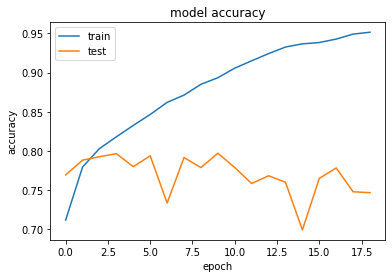

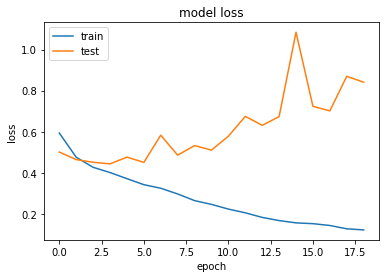

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()